In [145]:
import tensorflow as tf
from CovidCNN import CovidCNN
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Get the metadata
META = Path(".").resolve().joinpath("metadata.csv")

In [2]:
if tf.test.gpu_device_name():
    print(f"GPU Device: {tf.test.gpu_device_name()}\n")
else:
    print("Running off of CPU\n")

GPU Device: /device:GPU:0



In [3]:
def PlotAccuracies(history):
    fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(20,5))
    
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model Accuracy')
    ax.legend(['train', 'val'], loc='upper left')
    ax.set(xlabel="# of Epochs", ylabel="Accuracy")
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax.set(xlabel="# of Epochs", ylabel="Loss")
    ax2.legend(['train', 'val'], loc='upper left')
    
    plt.grid(False)

## Experiment 1.
##### This experiment is to gauge the baseline performance of the model before future improvements

In [4]:
# Call the CovidCNN class
baseline = CovidCNN(META)

Found 75697 validated image filenames belonging to 2 classes.
Found 18924 validated image filenames belonging to 2 classes.


In [5]:
# See what we're working with
baseline.Summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       7

In [6]:
# Train the model
baselineHistory = baseline.Train()

Epoch 1/20
591/591 [==============================] - 333s 564ms/step - loss: 0.0615 - accuracy: 0.9794 - val_loss: 0.1322 - val_accuracy: 0.9471

In [7]:
# Evaluate the models performance
baseline.Evaluate()

148/148 [==============================] - 69s 464ms/step - loss: 0.2737 - accuracy: 0.9417

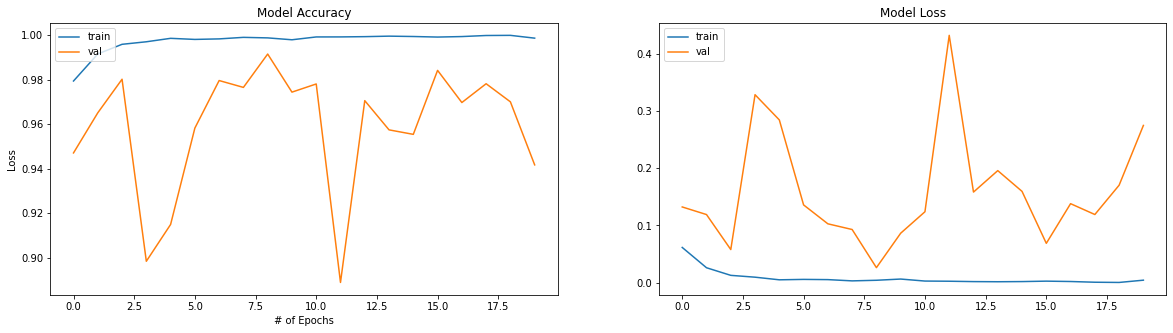

In [8]:
# Plot the accuracy and losses
PlotAccuracies(baselineHistory)

In [57]:
# The number of training steps must be ceiled so that the confusion matrix can be used otherwise the number of samples will be inconsistent
# Predictions > 0.5 are NON-COVID (1), < 0.5 are COVID (0)
predictions = baseline.model.predict(baseline.testing, math.ceil(baseline.testingSteps), verbose=1)
predictedClass = np.where(predictions > 0.5, 1, 0)

148/148 [==============================] - 66s 444ms/step

'cm = confusion_matrix(baseline.testing.classes, predictedClass)\nprint(cm)\n\nprint(classification_report(baseline.testing.classes, predictedClass))'

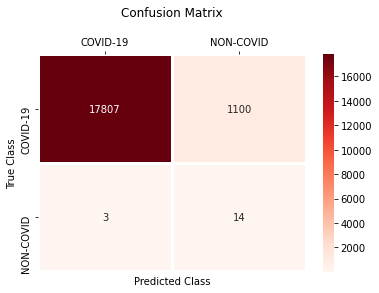

In [125]:
# Evaluate the accuracy of the classification with a confusion matrix
import seaborn as sns
cm = confusion_matrix(baseline.testing.classes, predictedClass)

labels = ["TP", "FP", "FN", "TN"]

f = sns.heatmap(cm,
                annot=True,
                fmt="g",
                linewidths=2,
                xticklabels=['COVID-19', "NON-COVID"],
                yticklabels=['COVID-19', "NON-COVID"],
                cmap="Reds")

f.set_title("Confusion Matrix\n")
f.set_ylabel("True Class")
f.set_xlabel("Predicted Class")
f.xaxis.tick_top()

In [136]:
# Build a report to show the main classification metrics
print(classification_report(baseline.testing.classes, predictedClass, target_names=["COVID-19", "NON-COVID"]))

              precision    recall  f1-score   support

    COVID-19       1.00      0.94      0.97     18907
   NON-COVID       0.01      0.82      0.02        17

    accuracy                           0.94     18924
   macro avg       0.51      0.88      0.50     18924
weighted avg       1.00      0.94      0.97     18924



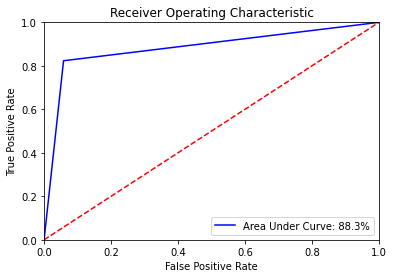

In [160]:
# Plot the ROC curve and the area under curve
fpr, tpr, thresholds = roc_curve(baseline.testing.classes, predictedClass)
auc = roc_auc_score(baseline.testing.classes, predictedClass)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label=f"Area Under Curve: {round(auc*100, 1)}%")
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()